# Haplotype analysis *CYP6* cluster

## Input

Input files:

In [1]:
# output
outdir   = "results_236M_UGS" # where to store output
outali   = "results_236M_UGS" # where to store haplotype alignments
popc     = "population"

# gene of interest
chrom     = "2R"
l_nom     = "cyp6"     # nom loci
loc_start = 28480576   # start CYP6 cluster
loc_end   = 28505816   # end CYP6 cluster
loc_p4    = 28497967   # polarizing mutation: I236M CYP6P4

# retain all variants between these coordinates
ret_start  = 0  
ret_end    = 100e6 # all variants

# min frq to retain minor allele
minfrq     = 0.05
# input data phase1
oc_metasam_fn = "/home/xavi/dades/Variation/phase1.AR3/samples/samples.meta.txt"
oc_hapcall_fn = "/home/xavi/dades/Variation/phase1.AR3/haplotypes/main/hdf5/ag1000g.phase1.ar3.haplotypes.2R.h5" 
oc_effcall_fn = "/home/xavi/dades/Variation/phase1.AR3/variation/zarr/ag1000g.phase1.ar3.pass/2R/" 
oc_accessi_fn = "/home/xavi/dades/Variation/phase1.AR3/accessibility/accessibility.h5"    
oc_popc       = popc
#oc_popl       = ["BFS","CMS","GAS","GNS","CMS","UGS","AOM","BFM","GWA","KES"]
oc_popl       = ["UGS"]


# extra mutations (zanzibar, duplications, etc)
kary_fn    = "data/p1_UGS_extramutations_CYP6.csv"
# gff
gffann_fn  = "data/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.9.gff3"

In [2]:
import numpy as np
import zarr
import pandas as pd
import allel
import h5py
import warnings
import scipy
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import cm
import seaborn as sns
import itertools
from mlxtend.evaluate import permutation_test
warnings.simplefilter('ignore')
import random

%run scripts_helper/hapclust.py

# load plot settings
sns.set(context="notebook",style="ticks",
        font_scale=1,font="Arial",palette="bright")

Color palette for networks (must be named!):

In [3]:
# define dictionary of pop colors
pos_colors = {
    "BFS" : "deepskyblue",
    "GAS" : "lightblue",
    "GNS" : "blue",
    "CMS" : "purple",
    "UGS" : "orange",
    "AOM" : "green",
    "BFM" : "lightgreen",
    "GWA" : "gray",
    "KES" : "lightgray"
}

var_colors = dict({
    -1 : "orange",
    0  : "lightgray",
    1  : "deepskyblue",
    2  : "blue",
    3  : "violet",
})


## Load data

### Phase1 variants

Population and sample data:

In [4]:
# load samples list with sample code, groupings, locations etc.
oc_samples_df   = pd.read_csv(oc_metasam_fn, sep='\t')
oc_samples_bool = (oc_samples_df[oc_popc].isin(oc_popl).values)
oc_samples      = oc_samples_df[oc_samples_bool]
oc_samples.reset_index(drop=True, inplace=True)

# indexed dictionary of populations
oc_popdict = dict()
for popi in oc_popl: 
    oc_popdict[popi]  = oc_samples[oc_samples[oc_popc] == popi].index.tolist()

# add an extra population composed of all other locations
oc_popdict["all"] = []
for popi in oc_popl:
    oc_popdict["all"] = oc_popdict["all"] + oc_popdict[popi]


# report
print("Data:")
print("* Samples     = ", oc_samples.shape[0])
print("* Populations = ", set(oc_samples[oc_popc]))
print(oc_samples.groupby(("population")).size())

Data:
* Samples     =  103
* Populations =  {'UGS'}
population
UGS    103
dtype: int64


Phased variants and genotypes:

In [5]:
# declare objects with variant data
#oc_hapcall   = zarr.open(oc_hapcall_fn)
oc_hapcall   = h5py.File(oc_hapcall_fn)
# variants of genotypes
print("Variants phased...")
oc_hapcall_var = oc_hapcall[chrom]["variants"]
oc_hapvars = allel.VariantChunkedTable(oc_hapcall_var,names=["POS","REF","ALT"],index="POS") 
print(oc_hapvars.shape)
# genotype data
print("Genotypes phased...")
oc_hapcall_hap = oc_hapcall[chrom]["calldata"]["genotype"]
oc_haploty     = allel.GenotypeChunkedArray(oc_hapcall_hap) 
oc_haploty     = oc_haploty.subset(sel1=oc_samples_bool)
print(oc_haploty.shape)

Variants phased...
(11332701,)
Genotypes phased...
(11332701, 103, 2)


Effects:

In [6]:
oc_effcall     = zarr.open(oc_effcall_fn)
oc_effvars     = allel.VariantChunkedTable(oc_effcall["variants"],names=[
    "POS","REF","ALT","ANN_HGVS_p","ANN_HGVS_c",
    "ANN_Annotation","ANN_AA_pos","ANN_CDS_pos",
    "ANN_Feature_ID","ANN_Gene_ID","ANN_Gene_Name"
],index="POS") 

Is effect among phased variants?

In [7]:
is_eff_in_phased = np.isin(oc_effvars["POS"], oc_hapvars["POS"])
np.unique(is_eff_in_phased,return_counts=True)

(array([False,  True]), array([ 2748269, 11332701]))

Expand phase of phased variants:

In [8]:
# recast haplotypes: drop ploidy
print("Expand phase haplotypes...")
oc_haploty_hap = oc_haploty.to_haplotypes()
print(oc_haploty_hap.shape)

Expand phase haplotypes...
(11332701, 206)


Is variant of interest there?

In [9]:
np.unique(oc_hapvars["POS"] == loc_p4, return_counts=True)

(array([False,  True]), array([11332700,        1]))

### Sample data

Merge metadata files, with sample codes, species and populations, for variants:

In [10]:
print("Cast sample metadata...")
oc_samples = pd.DataFrame(data={
    "ox_code"    :  oc_samples["ox_code"].values.tolist() ,
    "species"    :  oc_samples["m_s"].values.astype(str).tolist(),
    "population" :  oc_samples[oc_popc].values.tolist() ,
})
print(oc_samples.shape)

# rename species...
oc_samples["species"].values[oc_samples["species"].values == "M"]   = "col"
oc_samples["species"].values[oc_samples["species"].values == "S"]   = "gam"
oc_samples["species"].values[oc_samples["species"].values == "M/S"] = "gamcol"
oc_samples["species"].values[oc_samples["species"].values == "M-S"] = "gamcol"
oc_samples["species"].values[oc_samples["species"].values == "nan"] = "gamcol"

# obtain full population & species list
oc_popl = np.unique(oc_samples["population"].values)
oc_spsl = np.unique(oc_samples["species"].values)

Cast sample metadata...
(103, 3)


Merge metadata files, with sample codes, species and populations, for expanded phased variants:

In [11]:
print("Cast sample metadata...")
oc_sampleh = pd.DataFrame(data={
    "ox_code"    :  list(itertools.chain(*[[ s + 'a', s + 'b'] for s in oc_samples["ox_code"].values.tolist()])),    # takes col from oc_samples and duplicates it, a/b
    "species"    :  list(itertools.chain(*[[ s      , s      ] for s in oc_samples["species"].values.tolist()])),
    "population" :  list(itertools.chain(*[[ s      , s      ] for s in oc_samples["population"].values.tolist()]))
})
print(oc_sampleh.shape)

Cast sample metadata...
(206, 3)


Dictionaries of populations and species:

In [12]:
print("Population dict...")
oc_popdict = dict()
for popi in oc_popl: 
    oc_popdict[popi]  = oc_samples[oc_samples["population"] == popi].index.tolist()
oc_popdict["all"] = []
for popi in oc_popl:
    oc_popdict["all"] = oc_popdict["all"] + oc_popdict[popi]

print("Population dict phased...")
oc_popdich = dict()
for popi in oc_popl: 
    oc_popdich[popi]  = oc_sampleh[oc_sampleh["population"] == popi].index.tolist()
oc_popdich["all"] = []
for popi in oc_popl:
    oc_popdich["all"] = oc_popdich["all"] + oc_popdich[popi]

print("Species dict...")
oc_spsdict = dict()
for spsi in oc_spsl: 
    oc_spsdict[spsi]  = oc_samples[oc_samples["species"] == spsi].index.tolist()
    
print("Species dict phased...")
oc_spsdich = dict()
for spsi in oc_spsl: 
    oc_spsdich[spsi]  = oc_sampleh[oc_sampleh["species"] == spsi].index.tolist()

Population dict...
Population dict phased...
Species dict...
Species dict phased...


### Allele counts

Using both dictionaries:

In [13]:
print("Genotypes phased to allele counts (population)...")
oc_hapalco_pop = oc_haploty.count_alleles_subpops(subpops=oc_popdict)
print(oc_hapalco_pop.shape)

print("Haplotypes phased to allele counts (population)...")
oc_hapalco_hap_pop = oc_haploty_hap.count_alleles_subpops(subpops=oc_popdich)
print(oc_hapalco_hap_pop.shape)

Genotypes phased to allele counts (population)...
(11332701,)
Haplotypes phased to allele counts (population)...
(11332701,)


### Filters

#### Retain segregating and non-singletons

Define which phased variants to retain from phase1 (all other datasets will be recast to fit this):

In [14]:
# subset data: segregating alleles, biallelic and no singletons
print("Filters phased...")
oc_is_seg_h    = oc_hapalco_hap_pop["all"].is_segregating()[:] # segregating
oc_is_nosing_h = oc_hapalco_hap_pop["all"][:,:2].min(axis=1)>1 # no singletons

# subset phase2 to seg, nosing, biallelic & outgroup size
oc_hapvars_seg         = oc_hapvars.compress((oc_is_seg_h & oc_is_nosing_h))
oc_haploty_seg         = oc_haploty.compress((oc_is_seg_h & oc_is_nosing_h))
oc_hapalco_pop_seg     = oc_hapalco_pop.compress((oc_is_seg_h & oc_is_nosing_h))
oc_haploty_hap_seg     = oc_haploty_hap.compress((oc_is_seg_h & oc_is_nosing_h))
oc_hapalco_hap_pop_seg = oc_hapalco_hap_pop.compress((oc_is_seg_h & oc_is_nosing_h))

# report
print(oc_haploty_seg.shape,"/", oc_haploty.shape)

Filters phased...
(2738740, 103, 2) / (11332701, 103, 2)


Same for variant effects:

In [15]:
oc_effvars_seg_pos = oc_effvars["POS"][:][is_eff_in_phased].compress((oc_is_seg_h & oc_is_nosing_h))
oc_effvars_seg_ref = oc_effvars["REF"][:][is_eff_in_phased].compress((oc_is_seg_h & oc_is_nosing_h))
oc_effvars_seg_alt = oc_effvars["ALT"][:][is_eff_in_phased].compress((oc_is_seg_h & oc_is_nosing_h))
oc_effvars_seg_gen = oc_effvars["ANN_Feature_ID"][:][is_eff_in_phased].compress((oc_is_seg_h & oc_is_nosing_h))
oc_effvars_seg_pep = oc_effvars["ANN_HGVS_p"][:][is_eff_in_phased].compress((oc_is_seg_h & oc_is_nosing_h))
oc_effvars_seg_cds = oc_effvars["ANN_HGVS_c"][:][is_eff_in_phased].compress((oc_is_seg_h & oc_is_nosing_h))
oc_effvars_seg_typ = oc_effvars["ANN_Annotation"][:][is_eff_in_phased].compress((oc_is_seg_h & oc_is_nosing_h))
oc_effvars_seg_pep.shape

(2738740,)

Create array of printable variant names:

In [16]:
oc_snpname_seg = np.array(
    [chrom+":"+x1+" "+x2+" "+x3 for x1,x2,x3 in zip(
        oc_effvars_seg_pos.astype(str),
        oc_effvars_seg_gen.astype(str),
        oc_effvars_seg_pep.astype(str),
    )]
)

#### Retain min frequency and location

Is variant above certain minimum frequency? 

In [17]:
# allele counts table per pop
co_major = pd.DataFrame() 
co_minor = pd.DataFrame()
fq_minor = pd.DataFrame()
for popi in oc_popl: 
    co_major[popi] = oc_hapalco_pop_seg[popi][:,0]
    co_minor[popi] = oc_hapalco_pop_seg[popi][:,1]
    fq_minor[popi] = oc_hapalco_pop_seg[popi][:,1] / oc_hapalco_pop_seg[popi][:,0:2].sum(axis=1)
co_major["all"] = co_major.sum(axis=1)
co_minor["all"] = co_minor.sum(axis=1)
fq_minor["all"] = co_minor.sum(axis=1) / (co_minor.sum(axis=1)+co_major.sum(axis=1))

# subset data: keep variants with at least 5% freq in at least one pop
is_minfq  = np.logical_and(fq_minor.max(axis=1) > minfrq, fq_minor.min(axis=1) < 1-minfrq)

Is variant in the loci of interest? (useful for reporting)

In [18]:
is_in_loci = np.logical_and(oc_hapvars_seg["POS"] >= loc_start, oc_hapvars_seg["POS"] <= loc_end)

Is variant non syn?

In [19]:
is_nonsyn  = oc_effvars_seg_typ == "missense_variant"

Should variant frequency be reported? (in loci, nonsyn, min freq, segregating, non singleton):

In [20]:
# report
is_report  = (is_in_loci & is_minfq & is_nonsyn)
print("in loci:                    ",sum(is_in_loci))
print("in loci, nonsyn and min frq:",sum(is_report))

in loci:                     621
in loci, nonsyn and min frq: 43


Print table with variants, effects and frequencies per population:

In [21]:
# print table
fq_repor = pd.DataFrame(data={
    "chr"      : [chrom] * co_minor[is_in_loci].shape[0],
    "POS"      : oc_hapvars_seg["POS"].subset(sel0=is_in_loci)[:].astype(str),
    "REF"      : oc_hapvars_seg["REF"].subset(sel0=is_in_loci)[:].astype(str),
    "ALT"      : oc_hapvars_seg["ALT"].subset(sel0=is_in_loci)[:].astype(str),
    "is_nonsyn": is_nonsyn[is_in_loci],
    "gene_eff" : oc_effvars_seg_gen[is_in_loci].astype(str),
    "PEP_eff"  : oc_effvars_seg_pep[is_in_loci].astype(str),
    "CDS_eff"  : oc_effvars_seg_cds[is_in_loci].astype(str),
},
columns=["chr","POS","REF","ALT","gene_eff","PEP_eff","CDS_eff","is_nonsyn"]
)
fq_repor = pd.concat([fq_repor,fq_minor[is_in_loci].reset_index()],axis=1)
fq_repor.to_csv("%s/allele_fq.csv" % (outdir),sep="\t",index=False)

Print table with genotypes of nonsyn variants, per sample:

In [22]:
# dataframe with pops
gt_repor = pd.DataFrame(data={
    "ox_code"    : oc_samples["ox_code"],
    "population" : oc_samples["population"],
    "species"    : oc_samples["species"],
}
)

# retrieve 012 genotypes for report
gt_gtysa = pd.DataFrame(np.transpose(oc_haploty_seg.subset(sel0=is_report).to_n_alt(fill=-1)))
gt_gtysa.columns = oc_snpname_seg[is_report]

# print
gt_repor = pd.concat([gt_repor, gt_gtysa],axis=1)
gt_repor.to_csv("%s/allele_genotypes.csv" % (outdir),sep="\t",index=False)

### Other data

Accessibility:

In [23]:
# Accessibility
print("Load accessibility array...")
accessi_df  = h5py.File(oc_accessi_fn,mode="r")
accessi_arr = accessi_df[chrom]["is_accessible"][:]

Load accessibility array...


Gene annotations GFF:

In [24]:
# import gff
def geneset_gff(geneset):
    items = []
    for n in geneset.dtype.names:
        v = geneset[n]
        if v.dtype.kind == 'S':
            v = v.astype('U')
        items.append((n, v))
    return pd.DataFrame.from_items(items)
%run scripts_helper/plot_transcripts.py

geneset = allel.FeatureTable.from_gff3(gffann_fn,attributes=['ID', 'Parent'])
geneset = geneset_gff(geneset)


In [25]:
geneset[geneset["Parent"] == "AGAP002867"]

,seqid,source,type,start,end,score,strand,phase,ID,Parent
69657,2R,VectorBase,mRNA,28497087,28498674,-1.0,-,-1,AGAP002867-RA,AGAP002867


## Variant frequency

First, plot frequency of coding variants inside of the gene itself:

Minor allele freqs...


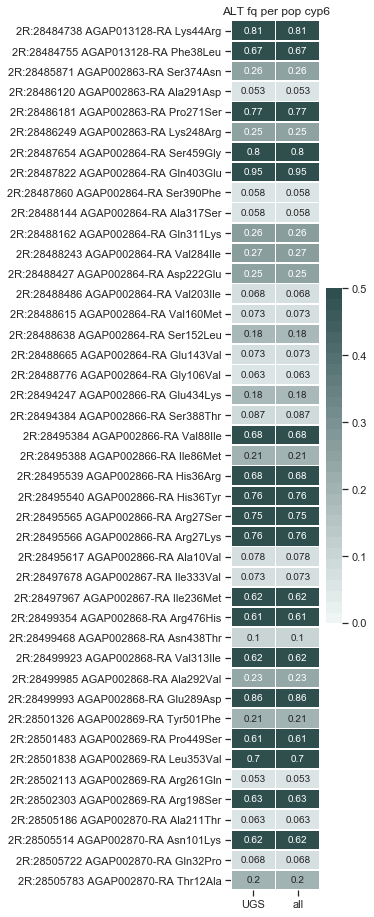

In [26]:
print("Minor allele freqs...")
    
# plot minor allele freqs per pop
fig = plt.figure(figsize=(2,16))
pdf = PdfPages("%s/allele_frequencies.pdf" % (outdir))

# plot
ax=sns.heatmap(fq_minor[is_report],vmin=0,vmax=0.5,cmap=sns.light_palette("darkslategray",n_colors=31),
               yticklabels=oc_snpname_seg[is_report],linewidths=0.8,linecolor="white",annot=True)
ax.set_title("ALT fq per pop %s" % l_nom)

pdf.savefig(fig,bbox_inches='tight')
pdf.close()

### Linkage disequilibrium

We calculate the **linkage disequilibrium** between all allele pairs, using two different metrics (Rogers & Huff $r$, Lewontin's $D'$). 

#### Rogers & Huff



LD Rogers & Huff...


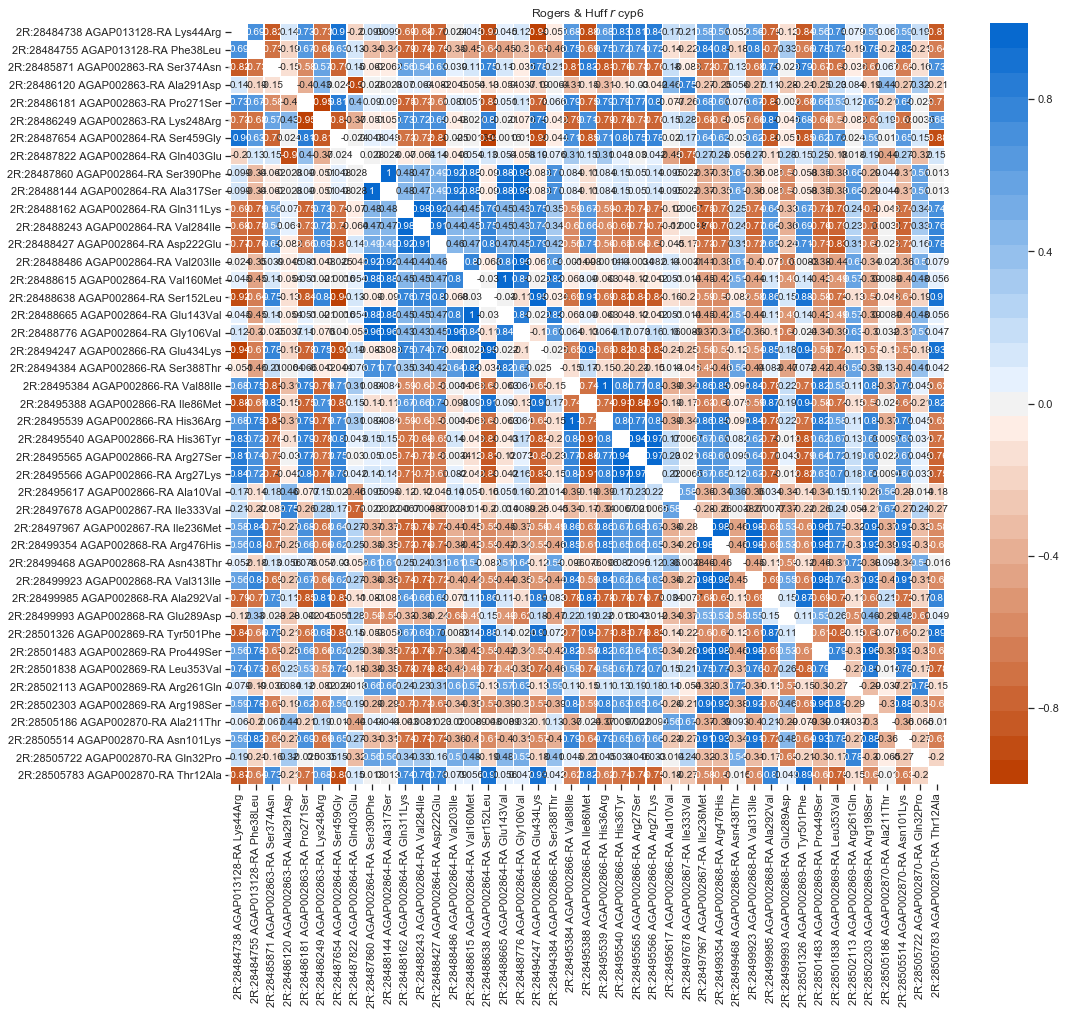

In [27]:
# linkage disequilibrium Rogers and Huff
print("LD Rogers & Huff...")
ld_rhr = allel.rogers_huff_r(oc_haploty_seg.compress(is_report).to_n_alt(fill=-1))
ld_rhr = squareform(ld_rhr)
np.fill_diagonal(ld_rhr,np.nan)

# plot
pdf = PdfPages("%s/allele_linkagediseq_rhr.pdf" % (outdir))
fig = plt.figure(figsize=(16,14))
ax=sns.heatmap(ld_rhr,vmin=-1,vmax=1,cmap=sns.diverging_palette(20,255,s=99,sep=15,l=45,n=31),
               xticklabels=oc_snpname_seg[is_report],yticklabels=oc_snpname_seg[is_report],linewidths=0.2,linecolor="white",annot=True)
ax.set_title("Rogers & Huff $r$ %s" % l_nom)
pdf.savefig(fig,bbox_inches='tight')
pdf.close()

# print table
ld_rhr_df = pd.DataFrame(ld_rhr)
ld_rhr_df.columns = oc_snpname_seg[is_report]
ld_rhr_df.rows    = oc_snpname_seg[is_report]
ld_rhr_df.to_csv("%s/allele_linkagediseq_rhr.csv" % (outdir),sep="\t",index=False)

#### Lewontin $D'$

Two functions for Lewontin $D'$:

In [28]:
def lewontin_d_prime(h, i, j, a=1, b=1):
    h = allel.HaplotypeArray(h)
    n_a = n_b = 0  # allele counts
    n_ab = 0  # haplotype counts
    n = 0  # allele number (i.e., number of calls)
    for k in range(h.n_haplotypes): # iterate over haplotypes, counting alleles and haplotypes
        allele_ik = h[i, k]
        allele_jk = h[j, k]
        if allele_ik < 0 or allele_jk < 0:    continue
        if allele_ik == a:                    n_a += 1
        if allele_jk == b:                    n_b += 1
        if allele_ik == a and allele_jk == b: n_ab += 1
        n += 1
    if n == 0 or n_a == 0 or n_b == 0 or n == n_a or n == n_b:
        return None # bail out if no data or either allele is absent or fixed
    # compute coefficient of linkage disequilibrium * n**2
    D_ab = (n * n_ab) - (n_a * n_b)
    # compute normalisation coefficient * n**2
    if D_ab >= 0: D_max = min(n_a * (n - n_b), (n - n_a) * n_b)
    else:         D_max = min(n_a * n_b, (n - n_a) * (n - n_b))
    # compute D prime
    D_prime = D_ab / D_max
    return D_prime

def lewontin_d_prime_varloop(h):
    n = len(h)
    ld = np.zeros((n, n), dtype='f8')
    for i,_ in enumerate(h):
        for j,_ in enumerate(h):
            if i != j:
                ld[i, j] = lewontin_d_prime(h=h,i=i,j=j)
    return(ld)

LD calculations:

LD Lewontin D'...


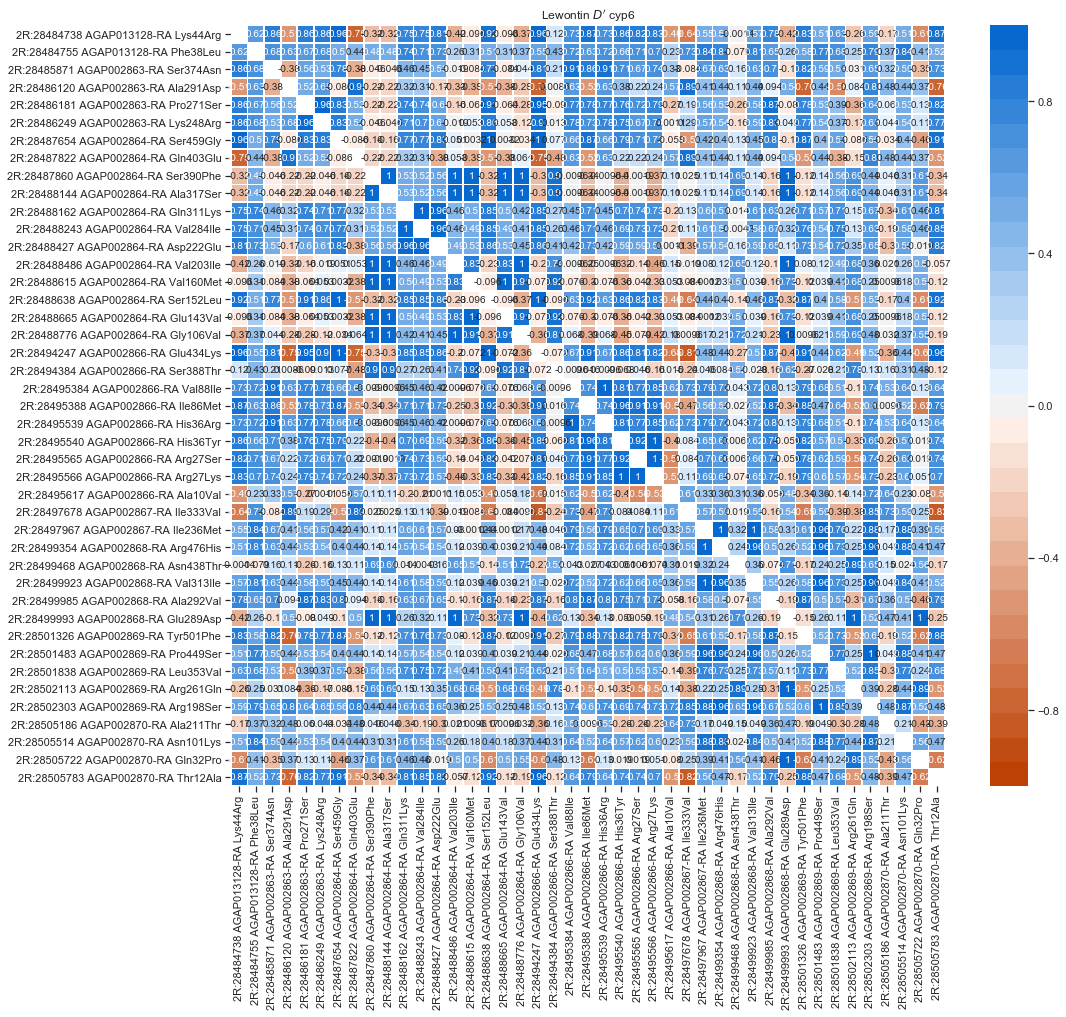

In [29]:
# lewontin D' linkage disequilibrium
print("LD Lewontin D'...")
ld_lewdp = lewontin_d_prime_varloop(h=oc_haploty_seg.compress(is_report).to_n_alt(fill=-1))     

# plot 
pdf = PdfPages("%s/allele_linkagediseq_LewD.pdf" % (outdir))
fig = plt.figure(figsize=(16,14))
np.fill_diagonal(ld_lewdp,np.nan)
ax=sns.heatmap(ld_lewdp,vmin=-1,vmax=1,cmap=sns.diverging_palette(20,255,s=99,sep=15,l=45,n=31),
               xticklabels=oc_snpname_seg[is_report],yticklabels=oc_snpname_seg[is_report],linewidths=0.8,linecolor="white",annot=True)
ax.set_title("Lewontin $D'$ %s" % l_nom)
pdf.savefig(fig,bbox_inches='tight')
pdf.close()

# print table
ld_lewdp_df = pd.DataFrame(ld_lewdp)
ld_lewdp_df.columns = oc_snpname_seg[is_report]
ld_lewdp_df.rows    = oc_snpname_seg[is_report]
ld_lewdp_df.to_csv("%s/allele_linkagediseq_LewD.csv" % (outdir),sep="\t",index=False)

## Haplotype networks

Visualize haplotype similarity with **haplotype networks**, built from phased variants around the `I236M CYP6P4` mutation.

In [30]:
# input hap networks
loc_vari = loc_p4     # variable to use as focus of hap networks -> position in the genome
loc_varn = "centre"   # name it

# parameters hap networks
fbp_hap  = 2e4     # num bp to retain around variant of interest (allele) to define core haplotyes, CC uses 6kbp
max_dist = 5       # dist that breaks edges; default is 5; CC uses 2 -> if network method is MJN, then it doesn't work for max_dist>1!!!!
max_alle = 1       # indirect variant breaks
net_meth = "msn"   # can be: minimum_spanning_network msn ; minimum_spanning_tree mst ; median_joining_network mjt
min_fq_h = 0.05    # min freq of the haplotype cluster, below that the component will be excluded from plots
min_fc_h = int(min_fq_h*oc_haploty_hap_seg.shape[1])

loc_vari_bool = np.any(oc_hapvars["POS"]   == loc_vari)
loc_vari_ix   = np.where(oc_hapvars["POS"] == loc_vari)[0][0]

# report
print("Is %i %s in phased array? %s: index %i " % (loc_vari,loc_varn,loc_vari_bool,loc_vari_ix))

Is 28497967 centre in phased array? True: index 6809110 


Subset haplotypes to focus on variants around focal locus:

In [31]:
# subset hap arrays to fit loci of interest (loci centre +/- fbp_hap)
loc_pos_ix = allel.SortedIndex(oc_hapvars_seg['POS'])
loc_pos_rn = loc_pos_ix.locate_range(loc_vari-fbp_hap,loc_vari+fbp_hap)

# snp name
oc_snpname_seg_mis = oc_snpname_seg
loc_hap    = oc_haploty_hap_seg[loc_pos_rn]
loc_snpnom = oc_effvars_seg_pep[loc_pos_rn]

# report
print("Phased variants and samples around %s:" % loc_vari,loc_hap.shape)

# color arrays
loc_colpos = np.array([pos_colors[p] for p in oc_sampleh["population"].values])
loc_gty_A  = oc_haploty_hap_seg[ np.where(loc_pos_ix==loc_vari)[0][0] ]       # genotype of A296G
loc_gty_T  = loc_gty_A
loc_colvar = np.array([var_colors[p] for p in loc_gty_T])

Phased variants and samples around 28497967: (1046, 206)


Build **hap networks colored by population**, and store which samples are in which component:

In [32]:
loc_graph, loc_distinct_sets, loc_components = graph_haplotype_network(
    h=loc_hap,
    max_dist=max_dist,   
    max_allele=max_alle, # for MJN only; default is 3
    show_node_labels=min_fc_h,
    distance_metric='hamming',network_method=net_meth,
    hap_colors=loc_colpos,variant_labels=loc_snpnom,
    return_components=True,show_singletons=False)

num_components = loc_components.shape[0]

# plot pdf
loc_graph.format = 'pdf'
loc_graph.attr(label='\n\n%s %s %s:%i\n%i haps clustered into %i clusters with %s maxdist %i, from %i phased vars located +/- %i bp' % (l_nom,loc_varn,chrom,loc_vari,loc_hap.shape[1],num_components,net_meth,max_dist,loc_hap.shape[0],fbp_hap))
fn = "%s/hapnet_%s_var_%s_%s-pop" % (outdir,net_meth,loc_vari,loc_varn)
loc_graph.render(fn,cleanup=True)

'results_236M_UGS/hapnet_msn_var_28497967_centre-pop.pdf'

In [33]:
# map hap clusters with REF alleles to actual lists of populations
# BEWARE: identify_components fails if max_dist > 1 in MJN
def identify_components(h_distinct_sets, components):
    """This function is designed to collect all indices for original haplotypes 
    within each connected component. I.e., it finds clusters from the network."""
    clusters = []
    for c in np.unique(components):
        cluster = set()
        for i in np.nonzero(components == c)[0]:
            cluster |= h_distinct_sets[i]
        clusters.append(sorted(cluster))
    return clusters

loc_components_id      = identify_components(loc_distinct_sets, loc_components) 
loc_components_id_hapi = []
loc_components_id_clui = []
loc_components_id_dati = pd.DataFrame()
for n,i in enumerate(loc_components_id):
    loc_components_id_hapi = loc_components_id_hapi + loc_components_id[n]
    loc_components_id_clui = loc_components_id_clui + list([n]*len(loc_components_id[n]))

loc_components_id_dati["hap_index"]   = loc_components_id_hapi
loc_components_id_dati["hap_cluster"] = loc_components_id_clui
loc_components_id_dati                = loc_components_id_dati.sort_values(by="hap_index")
loc_components_id_dati                = loc_components_id_dati.set_index(keys="hap_index")
loc_components_id_dati["pop"]         = oc_sampleh["population"].values
loc_components_id_dati["hap_id"]      = oc_sampleh["ox_code"].values

# report
print("total haps:",loc_hap.shape[1])
print("num haps per cluster (only clusters n>=%i):" % min_fc_h)
print(loc_components_id_dati.groupby(("hap_cluster")).size()[loc_components_id_dati.groupby(("hap_cluster")).size()>=min_fc_h])

total haps: 206
num haps per cluster (only clusters n>=10):
hap_cluster
0    113
1     35
dtype: int64


Which clusters should we print? Those with frequency > 1% in the cohort (`min_fc_h` and `min_fq_h` variables, defined above):

In [34]:
min_cluster_size = min_fc_h
    
# select clusters
clu_list_ids     = np.unique(loc_components_id_dati["hap_cluster"],return_counts=True)[0]
clu_list_cou     = np.unique(loc_components_id_dati["hap_cluster"],return_counts=True)[1]
clu_list_ids_fil = clu_list_ids[clu_list_cou >= min_cluster_size]
clu_list_cou_fil = clu_list_cou[clu_list_cou >= min_cluster_size]
loc_printhap     = np.isin(loc_components_id_dati["hap_cluster"].values, clu_list_ids_fil)

print(loc_varn,loc_vari,"print clusters:",clu_list_ids_fil,"\t\tsize of clusters: ",clu_list_cou_fil)
print(loc_varn,loc_vari,"print clusters total size:",sum(loc_printhap),"/",len(loc_printhap))

centre 28497967 print clusters: [0 1] 		size of clusters:  [113  35]
centre 28497967 print clusters total size: 148 / 206


In [35]:
loc_graph, loc_distinct_sets, loc_components = graph_haplotype_network(
    h=loc_hap.subset(sel1=loc_printhap),
    max_dist=max_dist,   
    max_allele=max_alle, # for MJN only; default is 3
    show_node_labels=100,
    distance_metric='hamming',network_method=net_meth,
    hap_colors=loc_colpos[loc_printhap],variant_labels=loc_snpnom,
    return_components=True,show_singletons=False)

num_components = loc_components.shape[0]

# plot pdf
loc_graph.format = 'pdf'
loc_graph.attr(label='\n\n%s %s %s:%i\n%i haps clustered into %i clusters with %s maxdist %i, from %i phased vars located +/- %i bp' % (l_nom,loc_varn,chrom,loc_vari,loc_hap.shape[1],num_components,net_meth,max_dist,loc_hap.shape[0],fbp_hap))
fn = "%s/hapnet_%s_var_%s_%s-pop_minfq" % (outdir,net_meth,loc_vari,loc_varn)
loc_graph.render(fn,cleanup=True)

'results_236M_UGS/hapnet_msn_var_28497967_centre-pop_minfq.pdf'

Plot haplotype networks colored by genotype in CYP6P4-I236M:

* 236I (wt) is gray (0)
* 236M is light blue (1)
* missing genotype is orange (-1)

In [36]:
loc_components_id_dati["CYP6P4_nonsyn"] = loc_gty_T

In [37]:
loc_graph, loc_distinct_sets, loc_components = graph_haplotype_network(
    h=loc_hap.subset(sel1=loc_printhap),
    max_dist=max_dist,   
    max_allele=max_alle, # for MJN only; default is 3
    show_node_labels=100,
    distance_metric='hamming',network_method=net_meth,
    hap_colors=loc_colvar[loc_printhap],variant_labels=loc_snpnom,
    return_components=True,show_singletons=False)

num_components = loc_components.shape[0]

# plot pdf
loc_graph.format = 'pdf'
loc_graph.attr(label='\n\n%s %s %s:%i\n%i haps clustered into %i clusters with %s maxdist %i, from %i phased vars located +/- %i bp' % (l_nom,loc_varn,chrom,loc_vari,loc_hap.shape[1],num_components,net_meth,max_dist,loc_hap.shape[0],fbp_hap))
fn = "%s/hapnet_%s_var_%s_%s-gty_minfq" % (outdir,net_meth,loc_vari,loc_varn)
loc_graph.render(fn,cleanup=True)

'results_236M_UGS/hapnet_msn_var_28497967_centre-gty_minfq.pdf'

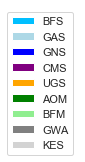

In [38]:
# plot color legend
# WARNING: colors might be slightly different because matplotlib and graphviz parse them differently
pdf = PdfPages("%s/hapnet_legend.pdf" % (outdir))
fig,ax = plt.subplots(figsize=(1,1))
ax.set_axis_off()
custom_lines = [mpatches.Patch(facecolor=pos_colors[coli]) for coli in pos_colors.keys()]
plt.legend(labels=pos_colors.keys(),handles=custom_lines)
pdf.savefig(fig,bbox_inches='tight')
pdf.close()

Now, output table with clusters, for posterity:

In [39]:
loc_components_id_dati.to_csv("%s/hapnet_result.csv" % (outdir),sep="\t",index=False)

### Distribution of populations per haplotype

Barplots:

In [40]:
def annotate_barplot(ax,color="k", labformat = "{:.2f}"):
    rects = ax.patches
    for rect in rects:
        x_value = rect.get_width()
        y_value = rect.get_y() + rect.get_height() / 2
        space   = 5
        ha      = 'left'
        label   = labformat.format(x_value) ## annotates bars with height labels, with 2 decimal points
        plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", va='center', ha=ha, color=color)


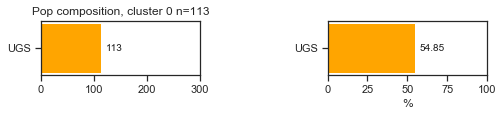

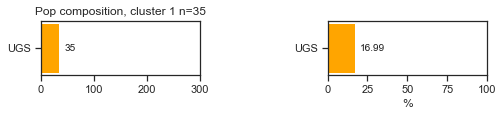

In [41]:
pdf = PdfPages("%s/hapnet_popcomp_perhap.pdf" % (outdir))

for i,clui in enumerate(clu_list_ids_fil):

    fig = plt.figure(figsize=(8,1))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.8, hspace=None)
    
    # and now: some barplots with pop composition of each cluster
    ax1 = plt.subplot(1, 2, 1)
    hap_labl = "Pop composition, cluster "+str(clui)+" n="+str(clu_list_cou_fil[i])
    hap_clui = loc_components_id_dati["hap_id"][loc_components_id_dati["hap_cluster"] == int(clui)]
    hap_popi = loc_components_id_dati["pop"][loc_components_id_dati["hap_cluster"] == int(clui)]
    pie_labels = ["UGS"]
    pie_counts = [len(np.where(hap_popi==popi)[0]) for popi in pie_labels]
    pie_colors = [pos_colors[popi] for popi in pie_labels]
    plt.barh(width=pie_counts[::-1],y=pie_labels[::-1],color=pie_colors[::-1])
    ax1.set_xlim(0,300)
    annotate_barplot(ax=ax1, labformat="{:.0f}")
    plt.title(hap_labl)

    # and next: some barplots with pop % of each cluster
    ax2 = plt.subplot(1, 2, 2)
    hap_labl = "% of haps from each pop in cluster"
    pie_coutot = oc_sampleh.groupby("population").size()
    pie_coutot = pie_coutot[pie_labels]
    pie_fracti = pie_counts / pie_coutot * 100
    plt.barh(width=pie_fracti[::-1],y=pie_labels[::-1],color=pie_colors[::-1])
    annotate_barplot(ax=ax2, labformat="{:.2f}")
    ax2.set_xlabel("%")
    ax2.set_xlim(0,100)

    pdf.savefig(fig,bbox_inches='tight')
    
pdf.close()

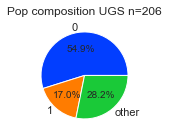

In [42]:
pdf = PdfPages("%s/hn_popcomp_perpop.pdf" % (outdir))

for popi in oc_popl:
    
    fig = plt.figure(figsize=(2,2))
    
    ax2 = plt.subplot(1, 1, 1)

    hap_popi = loc_components_id_dati["hap_cluster"][loc_components_id_dati["pop"] == popi]
    pie_coun = [sum(hap_popi == i) for i in clu_list_ids_fil]
    pie_coub = np.append(pie_coun, len(hap_popi)-sum(pie_coun))
    pie_labb = np.append(clu_list_ids_fil, "other")
    pie_titl = "Pop composition "+popi+" n="+str(len(hap_popi))
    ax2.pie(pie_coub,labels=pie_labb, autopct="%1.1f%%")
    plt.title(pie_titl)
    pdf.savefig(fig,bbox_inches='tight')
    
pdf.close()

## Selection signals in clusters

We want to see if the resistance haplotypes defined above have positive selection. 

In selection signal analyses, we cluster haplotypes in the following groups (derived from the networks above):

* `clu_236M`: cluster of n=113 haplotypes carrying 236M allele in Cyp6p4 codon 236 (and also duplications, zzb, etc). Same as `cluster_0` in networks above
* `clu_236I`: cluster of n=35 haplotypes with wt allele in Cyp6p4 codon 236. Same as `cluster_1` in networks above.
* `noclu`: unclustered haplotypes

In [43]:
min_cluster_size = 10
    
# select clusters
clu_list_ids     = np.unique(loc_components_id_dati["hap_cluster"],return_counts=True)[0]
clu_list_cou     = np.unique(loc_components_id_dati["hap_cluster"],return_counts=True)[1]
clu_list_gty     = np.array([np.unique(loc_components_id_dati["CYP6P4_nonsyn"][loc_components_id_dati["hap_cluster"] == clui].values)[0] for clui in clu_list_ids])
clu_list_ids_fil = clu_list_ids[clu_list_cou >= min_cluster_size]
clu_list_cou_fil = clu_list_cou[clu_list_cou >= min_cluster_size]

print(loc_varn,loc_vari,"print EHH for clusters:",clu_list_ids_fil,"\t\tsize of clusters: ",clu_list_cou_fil)

centre 28497967 print EHH for clusters: [0 1] 		size of clusters:  [113  35]


Create dictionary of associations haplotype-cluster:

In [44]:
popdich_clu = dict()

# clusters, and non clustered
popdich_clu["clu_236M"] = np.where(loc_components_id_dati["hap_cluster"] == 0)[0]
popdich_clu["clu_236I"] = np.where(loc_components_id_dati["hap_cluster"] == 1)[0]
popdich_clu["noclu"] = np.where(  np.logical_and(
    loc_components_id_dati["hap_cluster"] != 0 , 
    loc_components_id_dati["hap_cluster"] != 1 )  )[0]

# allele counts in these clusters:
oc_hapalco_hap_clu_seg = oc_haploty_hap_seg.count_alleles_subpops(subpops=popdich_clu)
oc_hapalco_hap_clu_seg.shape

(2738740,)

Colors for plot:

In [63]:
# list colors for each haplotype in popdich_clu.keys()
colors = ["red","turquoise","gray"]

### EHH decay

Now calculate **EHH decay** on the region of interest, using phased variants around the I236M mutation (+/- a certain number of bases).

EHH clu_236M
EHH clu_236I
EHH noclu


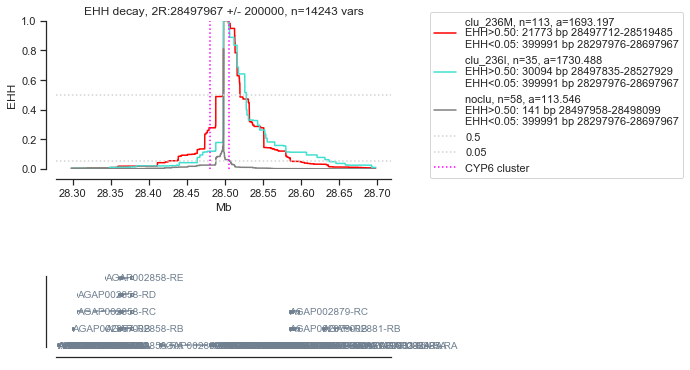

In [64]:
ehh_above_thr = 0.50
ehh_below_thr = 0.05
flank_bp_EHH  = 2e5

# variants to retain
clu_varbool_up = np.logical_and(oc_hapvars_seg["POS"] >= loc_vari-flank_bp_EHH, oc_hapvars_seg["POS"] < loc_vari)
clu_varbool_do = np.logical_and(oc_hapvars_seg["POS"] > loc_vari, oc_hapvars_seg["POS"] <= loc_vari+flank_bp_EHH)
clu_varbool    = np.logical_or(clu_varbool_up,clu_varbool_do)

# samples to remove from analysis (EHH function can't handle missing -1 data)
rmv_miss_ix   = np.unique(np.where(oc_haploty_hap_seg.subset(sel0=clu_varbool) == -1)[1]).tolist()
rmv_miss_bool = np.invert(np.isin(range(0,oc_haploty_hap_seg.n_haplotypes),test_elements=rmv_miss_ix))

# positions
clu_ehh_pos = oc_hapvars_seg["POS"].subset(sel0=clu_varbool)

# plot
pdf = PdfPages("%s/sel_EHHdecay_I236M.pdf" % (outdir))
fig = plt.figure(figsize=(6,6))
ax3 = plt.subplot(2, 1, 1)

for i,clu_key in enumerate(popdich_clu.keys()):

    print("EHH %s" % clu_key)

    # which variants include in the cluster-wise analysis of selection?
    clu_sambool = np.isin(range(0,oc_haploty_hap_seg.n_haplotypes),test_elements=popdich_clu[clu_key])
    clu_sambool = np.logical_and(clu_sambool,rmv_miss_bool)
    
    # calculate actual EHH
    clu_ehh_up_i = allel.ehh_decay(h=oc_haploty_hap_seg.subset(sel0=clu_varbool_up,sel1=clu_sambool))
    clu_ehh_do_i = allel.ehh_decay(h=oc_haploty_hap_seg.subset(sel0=clu_varbool_do,sel1=clu_sambool))
    clu_ehh_i    = np.concatenate((clu_ehh_up_i[::-1],clu_ehh_do_i))
    clu_ehh_i_ar = np.trapz(clu_ehh_i)
    ehh_above_start = clu_ehh_pos.compress(clu_ehh_i > ehh_above_thr)[0]
    ehh_above_end   = clu_ehh_pos.compress(clu_ehh_i > ehh_above_thr)[-1]
    ehh_below_start = clu_ehh_pos.compress(clu_ehh_i < ehh_below_thr)[0]
    ehh_below_end   = clu_ehh_pos.compress(clu_ehh_i < ehh_below_thr)[-1]

    # lab is data
    clu_lab    = "%s, n=%i, a=%.3f\nEHH>%.2f: %i bp %i-%i\nEHH<%.2f: %i bp %i-%i" % (
        clu_key, len(popdich_clu[clu_key]),clu_ehh_i_ar, 
        ehh_above_thr, ehh_above_end-ehh_above_start, ehh_above_start, ehh_above_end,
        ehh_below_thr, ehh_below_end-ehh_below_start, ehh_below_start, ehh_below_end
    )
    
    # plot EHH background & foreground
    ax3.plot(clu_ehh_pos/1e6,clu_ehh_i,color=colors[i],label=clu_lab,mfc='none')

sns.despine(ax=ax3,offset=10)
ax3.set_title("EHH decay, %s:%i +/- %i, n=%s vars" % (chrom,loc_vari,flank_bp_EHH,clu_ehh_pos.shape[0]))
ax3.set_xlabel("Mb")
ax3.set_ylabel("EHH")
ax3.set_ylim(0,1)
plt.axhline(ehh_above_thr, color='lightgray',linestyle=":",label=str(ehh_above_thr))
plt.axhline(ehh_below_thr, color='lightgray',linestyle=":",label=str(ehh_below_thr))
plt.axvline(loc_start/1e6, color='magenta',linestyle=":",label="CYP6 cluster")
plt.axvline(loc_end/1e6, color='magenta',linestyle=":",label="")
ax3.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

# plot transcripts
ax4 = plt.subplot(4, 1, 4)
sns.despine(ax=ax4,offset=10)
ax4.axes.get_xaxis().set_ticks([])
ax4.axes.get_xlabel() == ""
locus_genel = plot_transcripts(
    geneset=geneset,chrom=chrom,
    start=clu_ehh_pos[0],stop=clu_ehh_pos[-1],
    height=0.2,label_transcripts=True,ax=ax4,label_axis=False,
    color="slategray")

# save
pdf.savefig(fig,bbox_inches='tight')
pdf.close()

Same, but focusing on the duplication breakpoints rather than the 236M variant:

In [65]:
dup_start = 28480189
dup_end = 28483475

EHH clu_236M
EHH clu_236I
EHH noclu


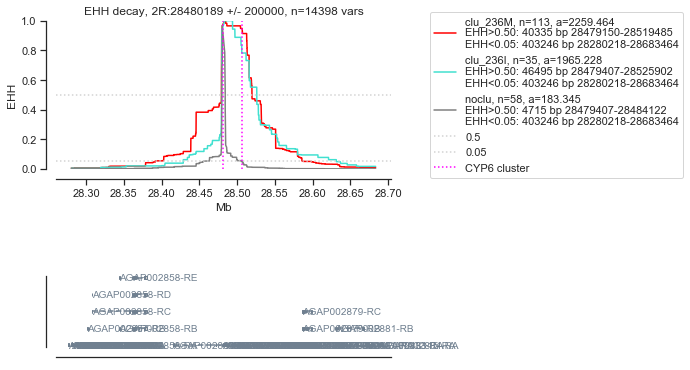

In [66]:
ehh_above_thr = 0.50
ehh_below_thr = 0.05
flank_bp_EHH  = 2e5

# variants to retain
clu_varbool_up = np.logical_and(oc_hapvars_seg["POS"] >= dup_start-flank_bp_EHH, oc_hapvars_seg["POS"] < dup_start)
clu_varbool_do = np.logical_and(oc_hapvars_seg["POS"] > dup_end, oc_hapvars_seg["POS"] <= dup_end+flank_bp_EHH)
clu_varbool    = np.logical_or(clu_varbool_up,clu_varbool_do)

# samples to remove from analysis (EHH function can't handle missing -1 data)
rmv_miss_ix   = np.unique(np.where(oc_haploty_hap_seg.subset(sel0=clu_varbool) == -1)[1]).tolist()
rmv_miss_bool = np.invert(np.isin(range(0,oc_haploty_hap_seg.n_haplotypes),test_elements=rmv_miss_ix))

# positions
clu_ehh_pos = oc_hapvars_seg["POS"].subset(sel0=clu_varbool)

# plot
pdf = PdfPages("%s/sel_EHHdecay_dup.pdf" % (outdir))
fig = plt.figure(figsize=(6,6))
ax3 = plt.subplot(2, 1, 1)

for i,clu_key in enumerate(popdich_clu.keys()):

    print("EHH %s" % clu_key)

    # which variants include in the cluster-wise analysis of selection?
    clu_sambool = np.isin(range(0,oc_haploty_hap_seg.n_haplotypes),test_elements=popdich_clu[clu_key])
    clu_sambool = np.logical_and(clu_sambool,rmv_miss_bool)
    
    # calculate actual EHH
    clu_ehh_up_i = allel.ehh_decay(h=oc_haploty_hap_seg.subset(sel0=clu_varbool_up,sel1=clu_sambool))
    clu_ehh_do_i = allel.ehh_decay(h=oc_haploty_hap_seg.subset(sel0=clu_varbool_do,sel1=clu_sambool))
    clu_ehh_i    = np.concatenate((clu_ehh_up_i[::-1],clu_ehh_do_i))
    clu_ehh_i_ar = np.trapz(clu_ehh_i)
    ehh_above_start = clu_ehh_pos.compress(clu_ehh_i > ehh_above_thr)[0]
    ehh_above_end   = clu_ehh_pos.compress(clu_ehh_i > ehh_above_thr)[-1]
    ehh_below_start = clu_ehh_pos.compress(clu_ehh_i < ehh_below_thr)[0]
    ehh_below_end   = clu_ehh_pos.compress(clu_ehh_i < ehh_below_thr)[-1]

    # lab is data
    clu_lab    = "%s, n=%i, a=%.3f\nEHH>%.2f: %i bp %i-%i\nEHH<%.2f: %i bp %i-%i" % (
        clu_key, len(popdich_clu[clu_key]),clu_ehh_i_ar, 
        ehh_above_thr, ehh_above_end-ehh_above_start, ehh_above_start, ehh_above_end,
        ehh_below_thr, ehh_below_end-ehh_below_start, ehh_below_start, ehh_below_end
    )
    
    # plot EHH background & foreground
    ax3.plot(clu_ehh_pos/1e6,clu_ehh_i,color=colors[i],label=clu_lab,mfc='none')

sns.despine(ax=ax3,offset=10)
ax3.set_title("EHH decay, %s:%i +/- %i, n=%s vars" % (chrom,dup_start,flank_bp_EHH,clu_ehh_pos.shape[0]))
ax3.set_xlabel("Mb")
ax3.set_ylabel("EHH")
ax3.set_ylim(0,1)
plt.axhline(ehh_above_thr, color='lightgray',linestyle=":",label=str(ehh_above_thr))
plt.axhline(ehh_below_thr, color='lightgray',linestyle=":",label=str(ehh_below_thr))
plt.axvline(loc_start/1e6, color='magenta',linestyle=":",label="CYP6 cluster")
plt.axvline(loc_end/1e6, color='magenta',linestyle=":",label="")
ax3.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

# plot transcripts
ax4 = plt.subplot(4, 1, 4)
sns.despine(ax=ax4,offset=10)
ax4.axes.get_xaxis().set_ticks([])
ax4.axes.get_xlabel() == ""
locus_genel = plot_transcripts(
    geneset=geneset,chrom=chrom,
    start=clu_ehh_pos[0],stop=clu_ehh_pos[-1],
    height=0.2,label_transcripts=True,ax=ax4,label_axis=False,
    color="slategray")

# save
pdf.savefig(fig,bbox_inches='tight')
pdf.close()

### Garud H and haplotype diversity

Compute **Garud H statistics and haplotype diversity** for each cluster and estimates in the region of interest (Cyp6 cluster). Plots represent a wide region around the Cyp6 cluster, and statistics are estimated from variants within the cluster only.

In [67]:
# region to plot
flanking_bp = 2e6
clu_varbool = np.logical_and(
    oc_hapvars_seg["POS"] >= loc_vari-flanking_bp,
    oc_hapvars_seg["POS"] <= loc_vari+flanking_bp)

# region to focus: statistics will be calcualted in this region
clu_varbool_focus = np.logical_and(oc_hapvars_seg["POS"] > loc_start, oc_hapvars_seg["POS"] <= loc_end)

First, for H12 plot:

clu_236M
H12 = 0.997076 +/- 0.002924 SE, n = 113
clu_236I
H12 = 1.000000 +/- 0.000000 SE, n = 35
noclu
H12 = 0.153488 +/- 0.009453 SE, n = 58


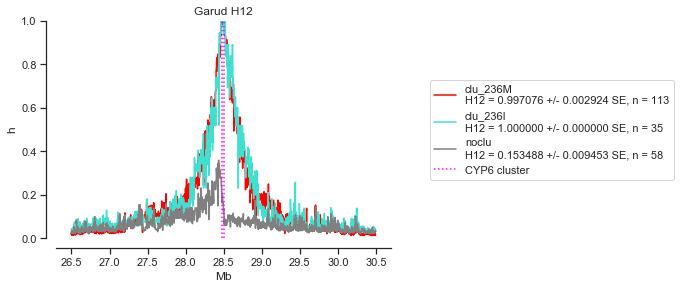

In [68]:
# open PDF
pdf = PdfPages("%s/sel_GarudH12.pdf" % (outdir))
fig = plt.figure(figsize=(6,4))
ax9 = plt.subplot(1, 1, 1)

for i,clu_key in enumerate(popdich_clu.keys()):

    # which variants include in the cluster-wise analysis of selection?
    clu_sambool = np.isin(range(0,oc_haploty_hap_seg.n_haplotypes),test_elements=popdich_clu[clu_key])
    clu_sambool = np.logical_and(clu_sambool,rmv_miss_bool)

    # Garud H along chromosome
    clu_pos_wib = allel.moving_statistic(
        oc_hapvars_seg["POS"].subset(sel0=clu_varbool), statistic=lambda v: v[0], size=100)
    clu_gah_wib = allel.moving_garud_h(
        oc_haploty_hap_seg.subset(sel0=clu_varbool,sel1=clu_sambool), size=100)
    
    # garud in focus region
    gah_focus_est = allel.moving_garud_h(oc_haploty_hap_seg.subset(sel0=clu_varbool_focus, sel1=clu_sambool), size=100)
    gah_focus_est_jack = allel.stats.misc.jackknife(gah_focus_est[1], statistic=np.nanmean)
    clu_label = "%s\nH12 = %.6f +/- %.6f SE, n = %i" % (clu_key, gah_focus_est_jack[0], gah_focus_est_jack[1],np.sum(clu_sambool))
    print(clu_label)

    # plot
    plt.subplot(1, 1, 1)
    plt.step(clu_pos_wib/1e6, clu_gah_wib[1], color=colors[i], label=clu_label)
    

sns.despine(ax=ax9,offset=10)
ax9.set_title("Garud H12")
ax9.set_ylim(0,1)
ax9.set_xlabel("Mb")
ax9.set_ylabel("h")
plt.axvline(loc_start/1e6, color='magenta',linestyle=":",label="CYP6 cluster")
plt.axvline(loc_end/1e6, color='magenta',linestyle=":",label="")
ax9.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

# save
pdf.savefig(fig,bbox_inches='tight')
pdf.close()

Now, same with H2/H1 plot:

clu_236M
H12 = 0.000040 +/- 0.000028 SE, n = 113
clu_236I
H12 = 0.000432 +/- 0.000193 SE, n = 35
noclu
H12 = 0.452041 +/- 0.032960 SE, n = 58


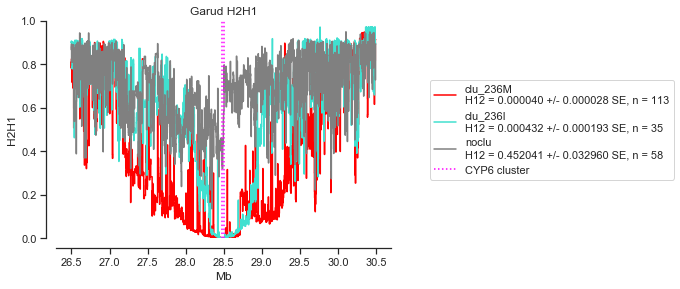

In [69]:
# open PDF
pdf = PdfPages("%s/sel_GarudH2H1.pdf" % (outdir))
fig = plt.figure(figsize=(6,4))
ax9 = plt.subplot(1, 1, 1)

for i,clu_key in enumerate(popdich_clu.keys()):

    # which variants include in the cluster-wise analysis of selection?
    clu_sambool = np.isin(range(0,oc_haploty_hap_seg.n_haplotypes),test_elements=popdich_clu[clu_key])
    clu_sambool = np.logical_and(clu_sambool,rmv_miss_bool)

    # Garud H along chromosome
    clu_pos_wib = allel.moving_statistic(
        oc_hapvars_seg["POS"].subset(sel0=clu_varbool), statistic=lambda v: v[0], size=100)
    clu_gah_wib = allel.moving_garud_h(
        oc_haploty_hap_seg.subset(sel0=clu_varbool,sel1=clu_sambool), size=100)
    
    # garud in focus region
    gah_focus_est = allel.moving_garud_h(oc_haploty_hap_seg.subset(sel0=clu_varbool_focus, sel1=clu_sambool), size=100)
    gah_focus_est_jack = allel.stats.misc.jackknife(gah_focus_est[3], statistic=np.nanmean)
    clu_label = "%s\nH12 = %.6f +/- %.6f SE, n = %i" % (clu_key, gah_focus_est_jack[0], gah_focus_est_jack[1],np.sum(clu_sambool))
    print(clu_label)

    # plot
    plt.subplot(1, 1, 1)
    plt.step(clu_pos_wib/1e6, clu_gah_wib[3], color=colors[i], label=clu_label)
    

sns.despine(ax=ax9,offset=10)
ax9.set_title("Garud H2H1")
ax9.set_ylim(0,1)
ax9.set_xlabel("Mb")
ax9.set_ylabel("H2H1")
plt.axvline(loc_start/1e6, color='magenta',linestyle=":",label="CYP6 cluster")
plt.axvline(loc_end/1e6, color='magenta',linestyle=":",label="")
ax9.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

# save
pdf.savefig(fig,bbox_inches='tight')
pdf.close()

Finally, haplotype diversity:

clu_236M
H12 = 0.008823 +/- 0.006022 SE, n = 113
clu_236I
H12 = 0.028571 +/- 0.012778 SE, n = 35
noclu
H12 = 0.919238 +/- 0.005962 SE, n = 58


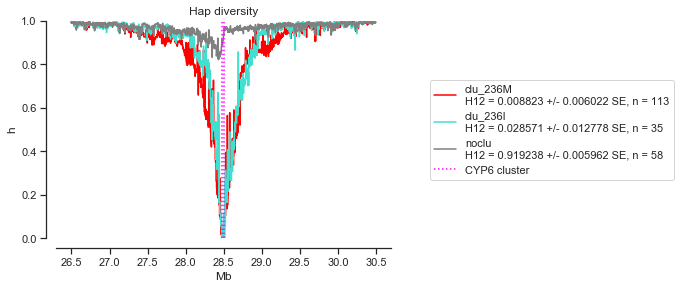

In [70]:
# open PDF
pdf = PdfPages("%s/sel_hapdiv.pdf" % (outdir))
fig = plt.figure(figsize=(6,4))
ax9 = plt.subplot(1, 1, 1)

for i,clu_key in enumerate(popdich_clu.keys()):

    # which variants include in the cluster-wise analysis of selection?
    clu_sambool = np.isin(range(0,oc_haploty_hap_seg.n_haplotypes),test_elements=popdich_clu[clu_key])
    clu_sambool = np.logical_and(clu_sambool,rmv_miss_bool)

    # hap div along chromosome
    clu_pos_wib = allel.moving_statistic(
        oc_hapvars_seg["POS"].subset(sel0=clu_varbool), statistic=lambda v: v[0], size=100)
    clu_hdi_wib = allel.moving_haplotype_diversity(
        oc_haploty_hap_seg.subset(sel0=clu_varbool,sel1=clu_sambool), size=100)
    
    # garud in focus region
    gah_focus_est = allel.moving_haplotype_diversity(oc_haploty_hap_seg.subset(sel0=clu_varbool_focus, sel1=clu_sambool), size=100)
    gah_focus_est_jack = allel.stats.misc.jackknife(gah_focus_est, statistic=np.nanmean)
    clu_label = "%s\nH12 = %.6f +/- %.6f SE, n = %i" % (clu_key, gah_focus_est_jack[0], gah_focus_est_jack[1],np.sum(clu_sambool))
    print(clu_label)

    # plot
    plt.subplot(1, 1, 1)
    plt.step(clu_pos_wib/1e6, clu_hdi_wib, color=colors[i], label=clu_label)
    
sns.despine(ax=ax9,offset=10)
ax9.set_title("Hap diversity")
ax9.set_ylim(0,1)
ax9.set_xlabel("Mb")
ax9.set_ylabel("h")
plt.axvline(loc_start/1e6, color='magenta',linestyle=":",label="CYP6 cluster")
plt.axvline(loc_end/1e6, color='magenta',linestyle=":",label="")
ax9.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

# save
pdf.savefig(fig,bbox_inches='tight')
pdf.close()

## Can we phase additional mutations?

If we find variants that are in high linkage disequilibrium with specimens that are 0 or 2 for the P4 mutation, we can use them to infer whether a particular haplotype has ZZB, dups, or indels.

First, load info of extra mutations:

In [53]:
kary_df = pd.read_csv(kary_fn, sep='\t')
print("extra mutations:",kary_df.shape)

extra mutations: (103, 4)


In [54]:
oc_haploty_seg_loci_extramut = np.vstack(
    (np.transpose(kary_df)[1:4],
     oc_haploty_seg.compress(is_in_loci).to_n_alt(fill=-1)[:])
)

print(oc_haploty_seg_loci_extramut.shape)

# calculate their LD
# linkage disequilibrium Rogers and Huff
print("LD Rogers & Huff...")
ld_rhr_extramut = allel.rogers_huff_r(oc_haploty_seg_loci_extramut)
ld_rhr_extramut = squareform(ld_rhr_extramut)
np.fill_diagonal(ld_rhr_extramut,np.nan)

(624, 103)
LD Rogers & Huff...


Are any of them in high linkage disequilibrium with the extra mutations?

In [55]:
ld_threshold = 0.95 ## I choose this threshold so as to obtain just one variant.
is_ld_zzb    = ld_rhr_extramut[0] >= ld_threshold
is_ld_dup    = ld_rhr_extramut[1] >= ld_threshold
is_ld_indel  = ld_rhr_extramut[2] >= ld_threshold

# how many?
print("zzb",sum(is_ld_zzb))
print("dup",sum(is_ld_dup))
print("indel",sum(is_ld_indel))

zzb 4
dup 0
indel 4


Which ones? For ZZB:

In [56]:
print(oc_snpname_seg[is_in_loci][is_ld_zzb[3:]])
print(ld_rhr_extramut[0][is_ld_zzb][1:])

['2R:28491424 AGAP002865-RA ' '2R:28497958 AGAP002867-RA Lys239Lys'
 '2R:28497967 AGAP002867-RA Ile236Met']
[0.9749238  0.95399505 0.95399505]


For the indel:

In [57]:
print(oc_snpname_seg[is_in_loci][is_ld_indel[3:]])
print(ld_rhr_extramut[2][is_ld_indel][1:])

['2R:28491424 AGAP002865-RA ' '2R:28497958 AGAP002867-RA Lys239Lys'
 '2R:28497967 AGAP002867-RA Ile236Met']
[0.9749238  0.95399505 0.95399505]


So we conclude that we can use `2R:28491424` as the tagging variant for the ZZB insertion and for the small deletion, because it has the highest LD (`r = 0.9749238`). But there are no variants linked to the duplication). 

Where is it?

In [58]:
is_tagvar   = oc_hapvars_seg["POS"] == 28491424
loc_gty_tag = oc_haploty_hap_seg.subset(sel0=is_tagvar)
np.unique(is_tagvar, return_counts=True)

(array([False,  True]), array([2738739,       1]))

### Export FASTA

We create a haplotype-level table with key genotypes, to use as the name for the haplotype sequences

* `zzb`: zanzibar presence/absence
* `indel`: indel presence/absence
* `tag`: presence/absence of the tagging allele `2R:28491424`, which tags zzb and indels
* `dup`: duplication presence/absence
* `gt`: I236 mutation in Cyp6P4
* `clu`: haplotype cluster (from networks above)
* also population & species: `UGgam`; and sample `ox_code`

In [59]:
kary_df_hap = pd.DataFrame(data={
    "ox_code" : list(itertools.chain(*[[ s + 'a', s + 'b'] for s in kary_df["ox_code"].values.tolist()])),    
    "zzb"     : list(itertools.chain(*[[ s      , s      ] for s in kary_df["zzb"].values.tolist()])),
    "dupaa1"  : list(itertools.chain(*[[ s      , s      ] for s in kary_df["dupaa1"].values.tolist()])),
    "indel"   : list(itertools.chain(*[[ s      , s      ] for s in kary_df["indel"].values.tolist()])),
    "tagvar"  : loc_gty_tag[0].tolist(),
})

kary_df_hap.shape

(206, 5)

Retrieve genotype of P4 allele:

In [60]:
oc_sampleh["P4_allele"] = loc_gty_T.astype(str)

Create alignment dataframe:

In [61]:
happhy = pd.DataFrame({
    "hap": ">"+oc_sampleh["ox_code"]+"_"+oc_sampleh["population"]+"_gt"+oc_sampleh["P4_allele"]+
    "_zzb"+kary_df_hap["zzb"].astype(str)+"_dup"+kary_df_hap["dupaa1"].astype(str)+"_indel"+kary_df_hap["indel"].astype(str)+
    "_clu"+loc_components_id_dati["hap_cluster"].values.astype(str)+"_tag"+kary_df_hap["tagvar"].astype(str),
    "seq": np.nan},    
    columns=["hap", "seq"])
happhy.head()

,hap,seq
0,>AC0090-Ca_UGS_gt1_zzb2_dup0_indel2_clu0_tag1,NaN
1,>AC0090-Cb_UGS_gt1_zzb2_dup0_indel2_clu0_tag1,NaN
2,>AC0091-Ca_UGS_gt1_zzb2_dup0_indel2_clu0_tag1,NaN
3,>AC0091-Cb_UGS_gt1_zzb2_dup0_indel2_clu0_tag1,NaN
4,>AC0092-Ca_UGS_gt1_zzb2_dup2_indel2_clu0_tag1,NaN


FASTA cluster:

In [62]:
export_name        = "loc" 
loc_varbool        = np.logical_and(oc_hapvars_seg["POS"][:] >= loc_start, oc_hapvars_seg["POS"][:] <= loc_end)
fa_haploty_hap_seg = oc_haploty_hap_seg.compress(loc_varbool)
fa_hapvars_seg     = oc_hapvars_seg.compress(loc_varbool)
print(export_name,fa_haploty_hap_seg.shape, fa_hapvars_seg.shape)

for pn,popi in enumerate(oc_sampleh["ox_code"]):
    
    if pn % int(happhy.shape[0]/10) == 0 : print(pn,"/",happhy.shape[0])
    popi_gen = np.ndarray.tolist(fa_haploty_hap_seg[:,pn])
    popi_seq = [fa_hapvars_seg["REF"][gn].astype(str) if gei == 0 else fa_hapvars_seg["ALT"][gn].astype(str) for gn,gei in enumerate(popi_gen)]
    happhy["seq"][pn] = ''.join(str(e) for e in popi_seq)

print(pn,"/",happhy.shape[0])
happhy.to_csv("%s/alig_%s.fasta" % (outali,export_name),sep="\n",index=False, header=False)
pd.DataFrame({
    "POS" : oc_hapvars_seg["POS"].subset(loc_varbool)[:]  
}).to_csv("%s/alig_%s.pos" % (outali,export_name),sep="\n",index=False, header=False)

loc (621, 206) (621,)
0 / 206
20 / 206
40 / 206
60 / 206
80 / 206
100 / 206
120 / 206
140 / 206
160 / 206
180 / 206
200 / 206
205 / 206
